In [1]:
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import os
import math
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score
import seaborn as sns
from sklearn import metrics
import time
import pickle
import metric_learn
from sklearn.decomposition import PCA  
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import LocalOutlierFactor
import functools
import tempfile
import datetime
import tensorflow as tf
import mlflow
from mlflow.models import infer_signature
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from utils import make_data, make_data_rev, make_label, calc_leq, leq_filter, validate, figure, figure_detail, plot_timeseries, fig_pr, auc_gs, fig_th_f

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16649177288556430713
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7798259712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14785653227821008015
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9500110053288144035
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7798259712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12105916535145816900
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
data_dir='filtered_csv_label'
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

,original,label,time,day
0,53.4,0,15,0
1,52.8,0,15,0
2,52.8,0,15,0
3,53.2,0,15,0
4,53.6,0,15,0
...,...,...,...,...
3995345,45.9,0,5,9
3995346,45.6,0,5,9
3995347,45.8,0,5,9
3995348,45.7,0,5,9


# クロスバリデーション
## 訓練、テストへ分割
* テスト（最終評価用）：6, 7, 8, 9 日目
---
ラベル付け
* 全体：0, 1, 2, 3, 4, 5 日目
* 訓練ローテ：(訓練、ラベル付与対象)=([0, 1, 2, 3, 4], 5)・・・([5, 0, 1, 2, 3], 4)

In [3]:
test_day=[6, 7, 8, 9]
semi_train_day=[0, 1, 2, 3, 4, 5]

test_df=df[(df['day'].isin(test_day))].reset_index(drop=True)
semi_train_df=df[(df['day'].isin(semi_train_day))].reset_index(drop=True)

In [4]:
df_list=[]

window=16
for i in set(df['day']):
    lag=[] 
    lag.append(make_data_rev(semi_train_df.loc[semi_train_df['day']==i, ['original']], 'original', window))
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['day']])
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
semi_train_df=pd.concat(df_list)
semi_train_df=semi_train_df.dropna().reset_index(drop=True)
semi_train_df.loc[:, 'convaed']=0
semi_train_df.loc[:, 'convaed_label']=0

In [5]:
semi_train_df

,original,original_next1,original_next2,original_next3,original_next4,original_next5,original_next6,original_next7,original_next8,original_next9,original_next10,original_next11,original_next12,original_next13,original_next14,original_next15,day,label,convaed,convaed_label
0,53.4,52.8,52.8,53.2,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9,0,0,0,0
1,52.8,52.8,53.2,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9,54.9,0,0,0,0
2,52.8,53.2,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9,54.9,55.0,0,0,0,0
3,53.2,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9,54.9,55.0,55.0,0,0,0,0
4,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9,54.9,55.0,55.0,55.2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393315,45.3,45.2,45.0,44.6,45.2,44.9,44.9,45.1,45.7,45.0,45.6,45.4,44.8,45.1,45.4,45.0,5,0,0,0
2393316,45.2,45.0,44.6,45.2,44.9,44.9,45.1,45.7,45.0,45.6,45.4,44.8,45.1,45.4,45.0,45.2,5,0,0,0
2393317,45.0,44.6,45.2,44.9,44.9,45.1,45.7,45.0,45.6,45.4,44.8,45.1,45.4,45.0,45.2,45.1,5,0,0,0
2393318,44.6,45.2,44.9,44.9,45.1,45.7,45.0,45.6,45.4,44.8,45.1,45.4,45.0,45.2,45.1,45.1,5,0,0,0


## Conv1D_autoencoder

In [6]:
# padding=sameは元の入力と同じ長さを出力がもつように入力にパディングする．
# （※正確には，入力の大きさをstridesの大きさで単純に割ったものが出力の大きさになる）
input_filter=25
latent_filter=1
kernel_size=6

conv_autoencoder = keras.Sequential(
    [
        layers.Conv1D(
            filters=input_filter,
            kernel_size=kernel_size,
            padding="same",
            strides=2,
            activation="relu",
        ),

        layers.Conv1D(
            filters=latent_filter,
            kernel_size=kernel_size,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=latent_filter,
            kernel_size=kernel_size,
            padding="same",
            strides=2,
            activation="relu",
        ),

        layers.Conv1DTranspose(
            filters=input_filter,
            kernel_size=kernel_size,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=kernel_size, padding="same"),
    ]
)

2024/01/05 12:28:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/01/05 12:28:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/01/05 12:28:27 INFO mlflow.tracking.fluent: Experiment with name 'CV' does not exist. Creating a new experiment.
2024/01/05 12:28:27 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a pri

訓練データ：[1, 2, 3, 4, 5]
ラベル付与データ：[0]日目


2024/01/05 12:28:30 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2024/01/05 12:28:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Arakawa\anaconda3\envs\tf291\lib\site-packages\mlflow\tensorflow\_autolog.py:52: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Epoch 1/100
7662/7662 [==============================] - 34s 4ms/step - loss: 0.0892 - val_loss: 0.0579
Epoch 2/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0560 - val_loss: 0.0557
Epoch 3/100
7662/7662 [==============================] - 29s 4ms/step - loss: 0.0543 - val_loss: 0.0548
Epoch 4/100
7662/7662 [==============================] - 29s 4ms/step - loss: 0.0536 - val_loss: 0.0599
Epoch 5/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0531 - val_loss: 0.0537
Epoch 6/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0528 - val_loss: 0.0550
Epoch 7/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0525 - val_loss: 0.0545
Epoch 8/100
7662/7662 [==============================] - 46s 6ms/step - loss: 0.0520 - val_loss: 0.0532
Epoch 9/100
7662/7662 [==============================] - 55s 7ms/step - loss: 0.0515 - val_loss: 0.0522
Epoch 10/100
7662/7662 [==============================] - 56s 7m

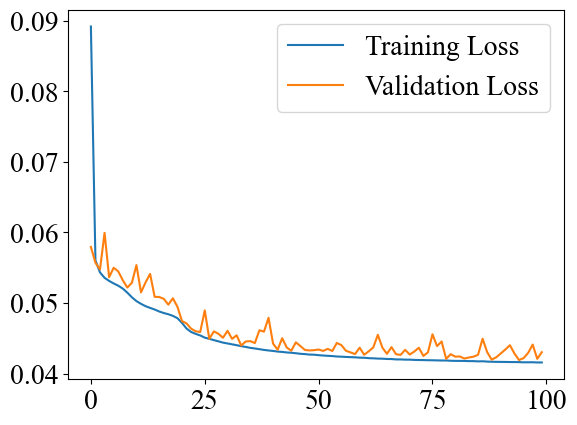

13500/13500 [==============================] - 16s 1ms/step
------------------------------------------------------


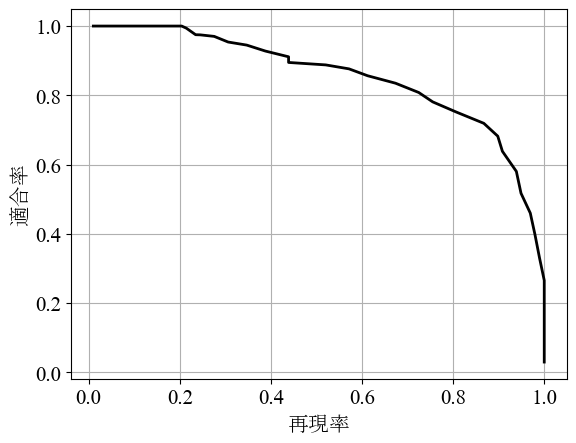

AUC：0.8460474719872499
理想の閾値：0.19999999999999998
F値（最高）：0.7863547604661955
適合率（F値が最高の時）：0.7191967324710687
再現率（F値が最高の時）：0.8673469387755102
訓練データ：[0, 2, 3, 4, 5]
ラベル付与データ：[1]日目
Epoch 1/100
8226/8226 [==============================] - 33s 4ms/step - loss: 0.0413 - val_loss: 0.0489
Epoch 2/100
8226/8226 [==============================] - 30s 4ms/step - loss: 0.0412 - val_loss: 0.0487
Epoch 3/100
8226/8226 [==============================] - 32s 4ms/step - loss: 0.0412 - val_loss: 0.0501
Epoch 4/100
8226/8226 [==============================] - 32s 4ms/step - loss: 0.0412 - val_loss: 0.0492
Epoch 5/100
8226/8226 [==============================] - 31s 4ms/step - loss: 0.0411 - val_loss: 0.0492
Epoch 6/100
8226/8226 [==============================] - 31s 4ms/step - loss: 0.0411 - val_loss: 0.0487
Epoch 7/100
8226/8226 [==============================] - 31s 4ms/step - loss: 0.0411 - val_loss: 0.0487
Epoch 8/100
8226/8226 [==============================] - 30s 4ms/step - loss: 0.0411 - val_loss:

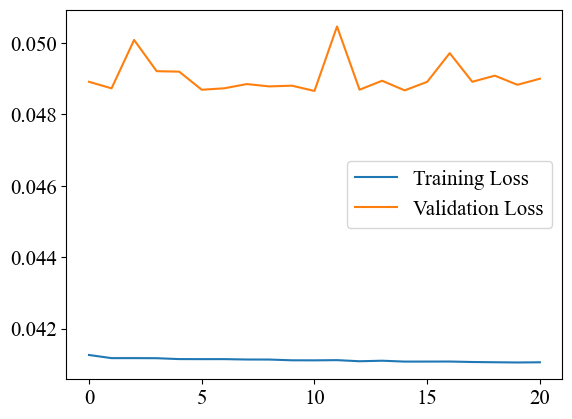

8984/8984 [==============================] - 11s 1ms/step
------------------------------------------------------


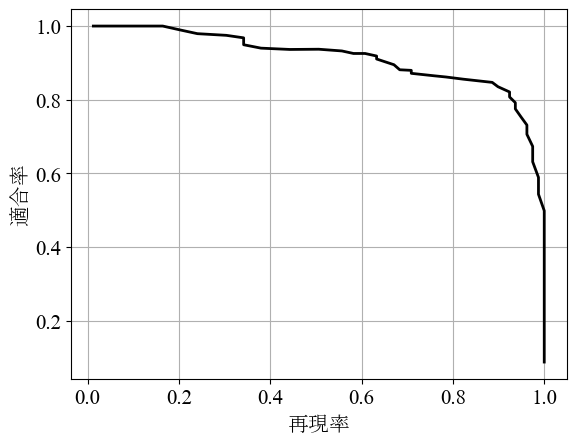

AUC：0.9019136034190699
理想の閾値：0.29230769230769227
F値（最高）：0.8694957731952557
適合率（F値が最高の時）：0.8210235131396957
再現率（F値が最高の時）：0.9240506329113924
訓練データ：[0, 1, 3, 4, 5]
ラベル付与データ：[2]日目
Epoch 1/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0409 - val_loss: 0.0452
Epoch 2/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0408 - val_loss: 0.0427
Epoch 3/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0408 - val_loss: 0.0430
Epoch 4/100
7662/7662 [==============================] - 29s 4ms/step - loss: 0.0408 - val_loss: 0.0430
Epoch 5/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0408 - val_loss: 0.0433
Epoch 6/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0408 - val_loss: 0.0427
Epoch 7/100
7662/7662 [==============================] - 29s 4ms/step - loss: 0.0408 - val_loss: 0.0428
Epoch 8/100
7662/7662 [==============================] - 29s 4ms/step - loss: 0.0408 - val_loss:

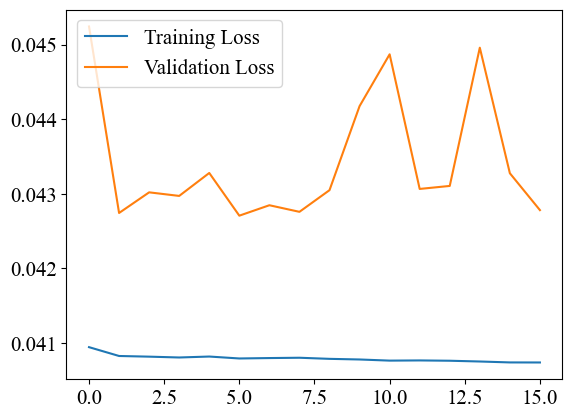

13500/13500 [==============================] - 16s 1ms/step
------------------------------------------------------


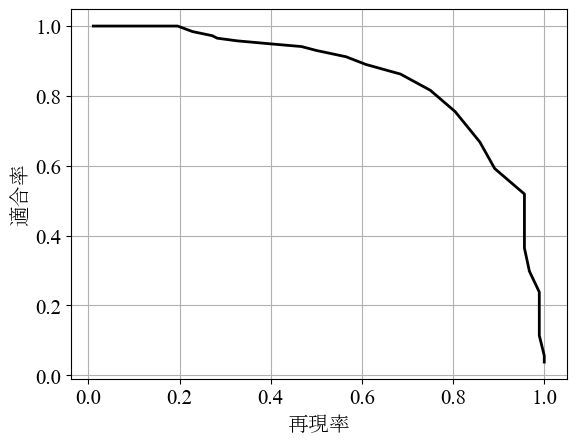

AUC：0.8458471307619735
理想の閾値：0.1846153846153846
F値（最高）：0.7816657027183344
適合率（F値が最高の時）：0.8161231884057971
再現率（F値が最高の時）：0.75
訓練データ：[0, 1, 2, 4, 5]
ラベル付与データ：[3]日目
Epoch 1/100
7873/7873 [==============================] - 32s 4ms/step - loss: 0.0422 - val_loss: 0.0355
Epoch 2/100
7873/7873 [==============================] - 31s 4ms/step - loss: 0.0421 - val_loss: 0.0355
Epoch 3/100
7873/7873 [==============================] - 31s 4ms/step - loss: 0.0421 - val_loss: 0.0352
Epoch 4/100
7873/7873 [==============================] - 30s 4ms/step - loss: 0.0421 - val_loss: 0.0354
Epoch 5/100
7873/7873 [==============================] - 31s 4ms/step - loss: 0.0421 - val_loss: 0.0353
Epoch 6/100
7873/7873 [==============================] - 31s 4ms/step - loss: 0.0421 - val_loss: 0.0352
Epoch 7/100
7873/7873 [==============================] - 30s 4ms/step - loss: 0.0421 - val_loss: 0.0353
Epoch 8/100
7873/7873 [==============================] - 31s 4ms/step - loss: 0.0421 - val_loss: 0.0353
Epoch 9

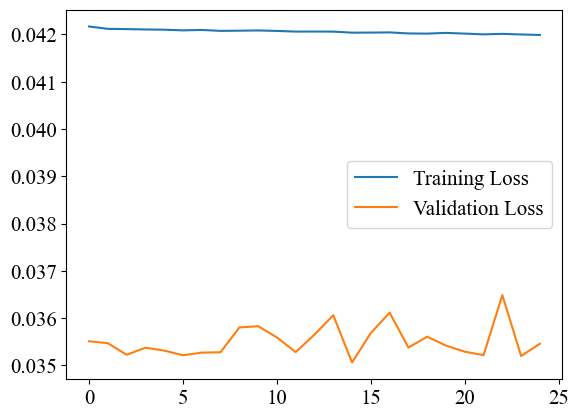

11812/11812 [==============================] - 14s 1ms/step
------------------------------------------------------


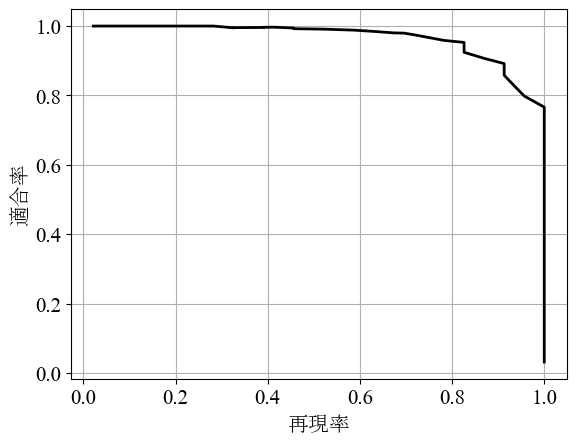

AUC：0.9450071213632389
理想の閾値：0.2769230769230769
F値（最高）：0.9022351650845278
適合率（F値が最高の時）：0.8916797488226059
再現率（F値が最高の時）：0.9130434782608695
訓練データ：[0, 1, 2, 3, 5]
ラベル付与データ：[4]日目
Epoch 1/100
7662/7662 [==============================] - 31s 4ms/step - loss: 0.0411 - val_loss: 0.0443
Epoch 2/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0411 - val_loss: 0.0445
Epoch 3/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0410 - val_loss: 0.0441
Epoch 4/100
7662/7662 [==============================] - 29s 4ms/step - loss: 0.0410 - val_loss: 0.0442
Epoch 5/100
7662/7662 [==============================] - 29s 4ms/step - loss: 0.0410 - val_loss: 0.0443
Epoch 6/100
7662/7662 [==============================] - 29s 4ms/step - loss: 0.0410 - val_loss: 0.0448
Epoch 7/100
7662/7662 [==============================] - 29s 4ms/step - loss: 0.0410 - val_loss: 0.0441
Epoch 8/100
7662/7662 [==============================] - 29s 4ms/step - loss: 0.0410 - val_loss: 

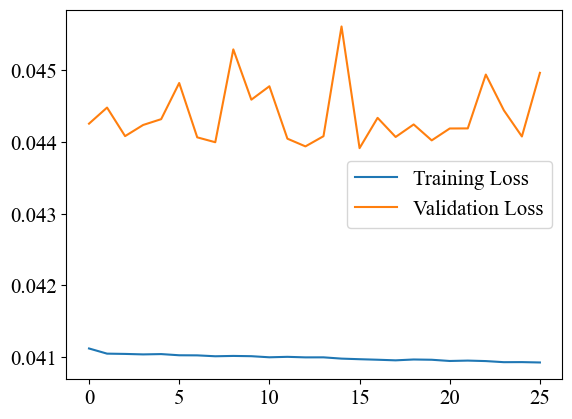

13499/13499 [==============================] - 17s 1ms/step
------------------------------------------------------


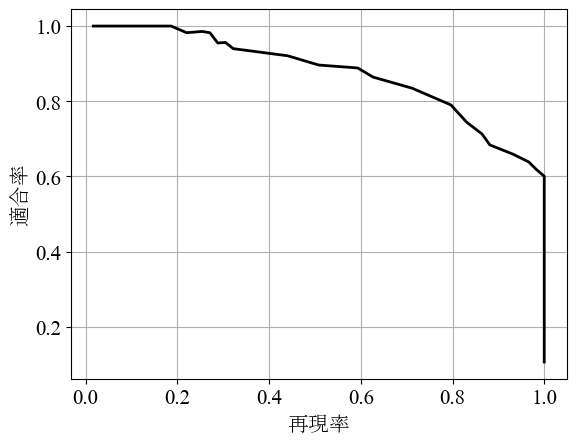

AUC：0.8596426422506389
理想の閾値：0.19999999999999998
F値（最高）：0.7933649104340876
適合率（F値が最高の時）：0.7901459854014599
再現率（F値が最高の時）：0.7966101694915254
訓練データ：[0, 1, 2, 3, 4]
ラベル付与データ：[5]日目
Epoch 1/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0430 - val_loss: 0.0362
Epoch 2/100
7662/7662 [==============================] - 29s 4ms/step - loss: 0.0429 - val_loss: 0.0368
Epoch 3/100
7662/7662 [==============================] - 29s 4ms/step - loss: 0.0429 - val_loss: 0.0362
Epoch 4/100
7662/7662 [==============================] - 29s 4ms/step - loss: 0.0429 - val_loss: 0.0371
Epoch 5/100
7662/7662 [==============================] - 29s 4ms/step - loss: 0.0429 - val_loss: 0.0374
Epoch 6/100
7662/7662 [==============================] - 29s 4ms/step - loss: 0.0429 - val_loss: 0.0358
Epoch 7/100
7662/7662 [==============================] - 29s 4ms/step - loss: 0.0429 - val_loss: 0.0364
Epoch 8/100
7662/7662 [==============================] - 29s 4ms/step - loss: 0.0429 - val_loss:

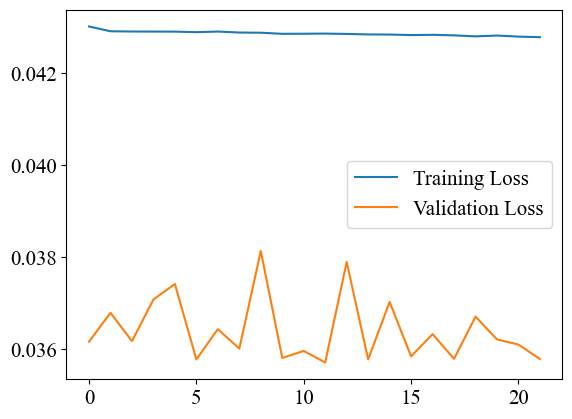

13500/13500 [==============================] - 16s 1ms/step
------------------------------------------------------


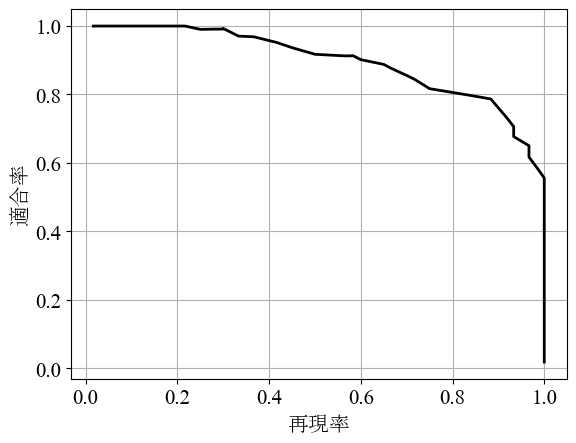

AUC：0.8811409441306571
理想の閾値：0.3384615384615384
F値（最高）：0.8323457169174086
適合率（F値が最高の時）：0.786923076923077
再現率（F値が最高の時）：0.8833333333333333
=============CV_AUC_mean===============
0.8799331523188049


In [7]:
mlflow.autolog(log_models=False)

# 実験をアクティブ化(設定)する。ない場合は新たな実験を作成してアクティブ化する
mlflow.set_experiment("CV")
run_name='result'
with mlflow.start_run(run_name=run_name):
    test_day=[6, 7, 8, 9]
    semi_train_day=[0, 1, 2, 3, 4, 5]
    mlflow.log_params({'CV_day':semi_train_day})
    auc_list=[]
    for day in semi_train_day:
        data_dir='filtered_csv_label'
        original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
        df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
        df=df[df['day']<=9]
        
        test_df=df[(df['day'].isin(test_day))].reset_index(drop=True)
        semi_train_df=df[(df['day'].isin(semi_train_day))].reset_index(drop=True)
        
        df_list=[]
        window=16
        for i in set(df['day']):
            lag=[] 
            lag.append(make_data_rev(semi_train_df.loc[semi_train_df['day']==i, ['original']], 'original', window))
            lag.append(semi_train_df.loc[semi_train_df['day']==i, ['day']])
            lag.append(semi_train_df.loc[semi_train_df['day']==i, ['label']])
            df_add_lag=pd.concat(lag, axis=1)
            df_list.append(df_add_lag)
        semi_train_df=pd.concat(df_list)
        semi_train_df=semi_train_df.dropna().reset_index(drop=True)
        semi_train_df.loc[:, 'convaed']=0
        semi_train_df.loc[:, 'convaed_label']=0
        # テストデータとする日
        i=[day]
        label_train_day=[k for k in semi_train_day if k not in i]
        label_grant_day=i
        print(f'訓練データ：{label_train_day}')
        print(f'ラベル付与データ：{label_grant_day}日目')
       
        semi_train_x=semi_train_df[(semi_train_df['day'].isin(label_train_day))][semi_train_df.columns[:-4]].reset_index(drop=True)
        labeling_x=semi_train_df[(semi_train_df['day'].isin(label_grant_day))][semi_train_df.columns[:-4]].reset_index(drop=True)
        train_mean=semi_train_x['original'].mean()
        train_std=semi_train_x['original'].std()

        #標準化
        train_data = (semi_train_x.values-train_mean)/train_std
        labeling_data = (labeling_x.values -train_mean) / train_std

        # データをモデルに入力する形状に整形し,データの型をtf.float32に変換
        train_data = tf.cast(train_data[:, :, np.newaxis], tf.float32)
        labeling_data = tf.cast(labeling_data[:, :, np.newaxis], tf.float32)

        conv_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                                 loss='mae')

        callback = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=10,
            restore_best_weights=True
        )
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        history = conv_autoencoder.fit(train_data, train_data, 
              epochs=100, 
              batch_size=256,
              validation_data=(labeling_data, labeling_data),
              callbacks=[callback],
              shuffle=True)

        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.show()

        reconstructions = conv_autoencoder.predict(labeling_data)
        #     異常度算出
        d= tf.keras.losses.mae(reconstructions[:, :, 0], labeling_data[:, :, 0]).numpy()
        semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'convaed']=d
        print('------------------------------------------------------')

        test_v=semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), ['original', 'label']].copy().reset_index(drop=True)
        d_test=(d-d.min())/(d.max()-d.min())

        thr_bins=50
        p_score, r_score, f_score, thresholds, thr, auc = fig_pr(test_v, d_test, thr_bins)
        f_max=f_score.max()
        p_max=p_score[np.argmax(f_score)]
        r_max=r_score[np.argmax(f_score)]
        print('\033[31m'+f'AUC：{auc}'+'\033[0m')
        print(f'理想の閾値：{thr}')
        print(f'F値（最高）：{f_max}')
        print(f'適合率（F値が最高の時）：{p_max}')
        print(f'再現率（F値が最高の時）：{r_max}')

        # Log the loss metric
        mlflow.log_metric("test_AUC", auc)
        mlflow.log_metric("test_Fscore_best", f_max)
        mlflow.log_metric("test_Precision_when Fscore Best", p_max)
        mlflow.log_metric("test_Recall_when Fscore Best", r_max)
        auc_list.append(auc)

    #平均
    auc_mean=np.mean(auc_list)
    # Log the loss metric
    mlflow.log_metric("CV_test_AUC", auc_mean)
    print('=============CV_AUC_mean===============')
    print(auc_mean)

## 訓練データとテストデータの重複を確認

In [12]:
semi_train_x.drop_duplicates()

,original,original_next1,original_next2,original_next3,original_next4,original_next5,original_next6,original_next7,original_next8,original_next9,original_next10,original_next11,original_next12,original_next13,original_next14,original_next15
0,53.4,52.8,52.8,53.2,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9
1,52.8,52.8,53.2,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9,54.9
2,52.8,53.2,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9,54.9,55.0
3,53.2,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9,54.9,55.0,55.0
4,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9,54.9,55.0,55.0,55.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961345,45.2,45.0,45.4,45.5,45.5,45.2,45.3,45.9,45.6,46.2,46.1,45.8,45.8,45.0,45.2,45.1
1961346,45.0,45.4,45.5,45.5,45.2,45.3,45.9,45.6,46.2,46.1,45.8,45.8,45.0,45.2,45.1,45.1
1961347,45.4,45.5,45.5,45.2,45.3,45.9,45.6,46.2,46.1,45.8,45.8,45.0,45.2,45.1,45.1,45.2
1961348,45.5,45.5,45.2,45.3,45.9,45.6,46.2,46.1,45.8,45.8,45.0,45.2,45.1,45.1,45.2,45.3


In [13]:
labeling_x.drop_duplicates()

,original,original_next1,original_next2,original_next3,original_next4,original_next5,original_next6,original_next7,original_next8,original_next9,original_next10,original_next11,original_next12,original_next13,original_next14,original_next15
0,46.9,47.2,47.4,47.8,47.9,47.8,48.4,49.0,49.7,50.5,52.0,53.0,54.5,54.7,55.5,55.0
1,47.2,47.4,47.8,47.9,47.8,48.4,49.0,49.7,50.5,52.0,53.0,54.5,54.7,55.5,55.0,55.7
2,47.4,47.8,47.9,47.8,48.4,49.0,49.7,50.5,52.0,53.0,54.5,54.7,55.5,55.0,55.7,55.7
3,47.8,47.9,47.8,48.4,49.0,49.7,50.5,52.0,53.0,54.5,54.7,55.5,55.0,55.7,55.7,56.0
4,47.9,47.8,48.4,49.0,49.7,50.5,52.0,53.0,54.5,54.7,55.5,55.0,55.7,55.7,56.0,56.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431965,45.3,45.2,45.0,44.6,45.2,44.9,44.9,45.1,45.7,45.0,45.6,45.4,44.8,45.1,45.4,45.0
431966,45.2,45.0,44.6,45.2,44.9,44.9,45.1,45.7,45.0,45.6,45.4,44.8,45.1,45.4,45.0,45.2
431967,45.0,44.6,45.2,44.9,44.9,45.1,45.7,45.0,45.6,45.4,44.8,45.1,45.4,45.0,45.2,45.1
431968,44.6,45.2,44.9,44.9,45.1,45.7,45.0,45.6,45.4,44.8,45.1,45.4,45.0,45.2,45.1,45.1


In [14]:
duplicates = pd.merge(semi_train_x.drop_duplicates(), labeling_x.drop_duplicates(), how='inner')
duplicates

,original,original_next1,original_next2,original_next3,original_next4,original_next5,original_next6,original_next7,original_next8,original_next9,original_next10,original_next11,original_next12,original_next13,original_next14,original_next15


In [8]:
! mlflow gc --backend-store-uri ./mlruns

In [1]:
! mlflow ui --port 5003 

^C


In [10]:
auc_list

[0.8460474719872499,
 0.9019136034190699,
 0.8458471307619735,
 0.9450071213632389,
 0.8596426422506389,
 0.8811409441306571]